In [1]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

from fastai.conv_learner import *


/home/katou/anaconda3/envs/GPU/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [3]:
location = 'home'

if(location == 'home'):
    PATH = '/home/katou/Python/GitHubRepo/Data/Kaggle Salt Id/'
elif(location == 'work'):
    PATH = 'C:\\Users\\SCatheline\\Documents\\GitHub repo\\FirstTest\\Kaggle_Challenge_LIVE-master\\data\\'
else:
    print('Unavailable location.')
#train image + mask data
train_mask = pd.read_csv(PATH+'train.csv')
#depth data
depth = pd.read_csv(PATH+'depths.csv')
#training path
train_path = PATH+'train'

#list of files
file_list = list(train_mask['id'].values)
#define our dataset using our class
dataset = TGSSaltDataset(train_path, file_list)

In [4]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

In [5]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [6]:
bs = 64
sz = 128
im_width = sz
im_height = sz
border = 5
im_chan = 3 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth

In [7]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"/images"))[2] if location == 'home' else next(os.walk(train_path+"\\images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float64)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float64)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float64)
M = np.zeros((len(train_ids),), dtype=np.float64)
SQ = np.zeros((len(train_ids),1), dtype=np.float64)   #salt quantity in image
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True) if location == 'home' else load_img(path + '\\images\\' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (sz, sz, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True)) if location == 'home' else img_to_array(load_img(path + '\\masks\\' + id_, grayscale=True))
    mask = resize(mask, (sz, sz, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    #X[n, ..., 1] = x_csum.squeeze()
    X[n, ..., 2] = x_img.squeeze() / 255
    X[n, ..., 1] = x_img.squeeze() / 255
    M[n] = np.mean(x_img.squeeze() / 255)
    y[n] = mask / 255
    SQ[n] = np.mean(y[n])

print('Done!')

MM = np.mean(M)
SS = np.std(M)

Using TensorFlow backend.


Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]/home/katou/anaconda3/envs/GPU/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:14<00:00, 271.63it/s]

Done!


In [8]:
from sklearn.model_selection import train_test_split

#split the data using the coverage of salt in the image
Cov = np.zeros((y.shape[0],),dtype = float)
for i in range(y.shape[0]):
    Cov[i] = int(round(10*np.mean(y[i,:,:,0])))


X_train, X_valid, SQ_train, SQ_valid, ids_train, ids_valid = train_test_split(X, SQ, train_ids, test_size=0.15, stratify=Cov, random_state=42)


print(X_train.shape)
print(X_valid.shape)
print(SQ_train.shape )
print(SQ_valid.shape)

(3400, 128, 128, 3)
(600, 128, 128, 3)
(3400, 1)
(600, 1)


In [9]:
#plt.hist(SQ_train)

In [10]:
#plt.hist(SQ_valid)

In [11]:
PATH='./'

In [12]:
def ReshapeData(X):
    return X.reshape(X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])

X_train2 = ReshapeData(X_train)
X_valid2 = ReshapeData(X_valid)

print(X_train2.shape)
print(X_valid2.shape)

(3400, 49152)
(600, 49152)


## Compute the statistics of the images


In [13]:
MM = np.mean(M)
SS = np.std(M)
stats = (np.array([MM, MM, MM]), np.array([SS, SS, SS]))

In [14]:
print(stats)

(array([0.47039, 0.47039, 0.47039]), array([0.11278, 0.11278, 0.11278]))


In [15]:
ImageClassifierData.from_arrays??

In [16]:
def get_data(sz,bs,stats):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()])
    return ImageClassifierData.from_arrays(PATH, trn = (X_train,SQ_train),val = (X_valid,SQ_valid), test = (X_train,SQ_train), tfms=tfms, bs=bs, continuous=True)

In [17]:
data = get_data(sz,bs,stats)

In [18]:
arch=resnet34 

In [19]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [20]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [21]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = self.drop(l3(l2(l(x))))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.out(x))  #F.log_softmax(self.out(x), dim=-1)

In [22]:
def mse(preds, targs):
    loss = nn.MSELoss()
    return loss(preds,targs)

In [23]:
learn = ConvLearner.pretrained(arch, data)

In [24]:
learn.opt_fn=optim.Adam

In [25]:
learn.load('salt_pred_resnet')

In [27]:
log_preds_valid = learn.predict()

(array([319.,  46.,  32.,  36.,  43.,  36.,  27.,  32.,  20.,   9.]),
 array([-0.01998,  0.07851,  0.17701,  0.27551,  0.374  ,  0.4725 ,  0.57099,  0.66949,  0.76799,  0.86648,
         0.96498], dtype=float32),
 <a list of 10 Patch objects>)

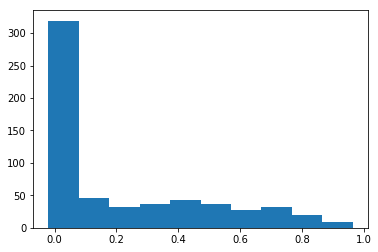

In [28]:
plt.hist(log_preds_valid)

(array([324.,  43.,  29.,  27.,  34.,  32.,  29.,  18.,  30.,  34.]),
 array([0.     , 0.09963, 0.19927, 0.2989 , 0.39853, 0.49817, 0.5978 , 0.69744, 0.79707, 0.8967 , 0.99634]),
 <a list of 10 Patch objects>)

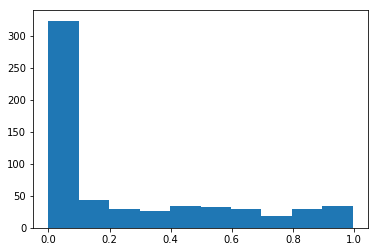

In [29]:
plt.hist(SQ_valid)

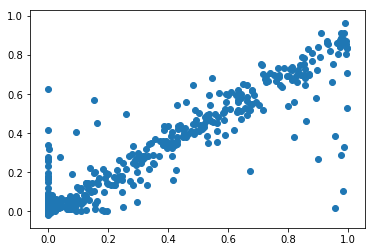

In [30]:
plt.scatter(SQ_valid,log_preds_valid)

In [31]:
log_preds_train = learn.predict(is_test=True)

(array([1894.,  277.,  230.,  244.,  219.,  165.,  196.,  155.,   17.,    3.]),
 array([-0.02506,  0.09992,  0.22489,  0.34986,  0.47483,  0.59981,  0.72478,  0.84975,  0.97472,  1.0997 ,
         1.22467], dtype=float32),
 <a list of 10 Patch objects>)

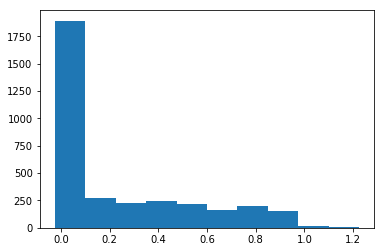

In [32]:
plt.hist(log_preds_train)

(array([1815.,  253.,  193.,  160.,  191.,  173.,  145.,  129.,  129.,  212.]),
 array([0.     , 0.09966, 0.19932, 0.29899, 0.39865, 0.49831, 0.59797, 0.69763, 0.79729, 0.89696, 0.99662]),
 <a list of 10 Patch objects>)

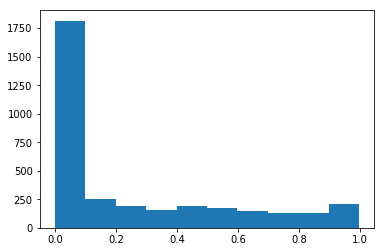

In [33]:
plt.hist(SQ_train)

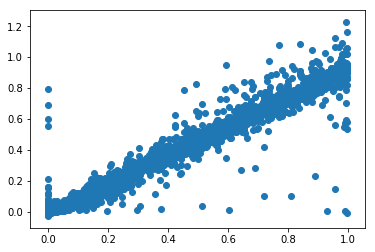

In [34]:
plt.scatter(SQ_train,log_preds_train)

In [64]:
min(log_preds_train)

array([0.00301])

In [65]:
min(log_preds_valid)

array([0.00724])

# Save prediction in .csv to be loaded during the NN training as part of the features

In [66]:
import pandas as pd

In [67]:
df_val = pd.DataFrame({'id': ids_valid, 'salt prop' : log_preds_valid[:,0]})

In [68]:
df_val.head(5)

,id,salt prop
0,bfd1d7caa1.png,0.494934
1,abd1e3e008.png,0.453759
2,7fd5baaee8.png,0.644281
3,4e86258646.png,0.684301
4,4b0c5aad63.png,0.317230


In [69]:
df_train = pd.DataFrame({'id': ids_train, 'salt prop' : log_preds_train[:,0]})

In [70]:
df_train.head(5)

,id,salt prop
0,ed081aa065.png,0.259938
1,f7b1bd7c8a.png,0.416743
2,ceca04aa2a.png,0.496852
3,1abf3d7f60.png,0.432304
4,cba568b15f.png,0.549547


In [76]:
len(df_val)

600

In [77]:
df_all = df_train

In [80]:
df_all = df_all.append(df_val)

In [81]:
len(df_all)

4000

In [82]:
df_all.to_csv('salt_prop.csv')

In [83]:
df_new = pd.read_csv('salt_prop.csv')

In [84]:
df_new.head(5)

,Unnamed: 0,id,salt prop
0,0,ed081aa065.png,0.259938
1,1,f7b1bd7c8a.png,0.416743
2,2,ceca04aa2a.png,0.496852
3,3,1abf3d7f60.png,0.432304
4,4,cba568b15f.png,0.549547


In [44]:
X_train2 = np.transpose(X_train, (0,3, 1, 2))
X_valid2 = np.transpose(X_valid, (0,3, 1, 2))

In [45]:
X_train2.shape

(3400, 3, 128, 128)

In [46]:
X_valid2.shape

(600, 3, 128, 128)

In [47]:
from torch.utils.data import DataLoader

In [48]:
trainloader = DataLoader(X_train2, batch_size=bs, shuffle=False, num_workers=4)

In [49]:
log_preds_train = np.zeros((X_train2.shape[0],1))

In [50]:
c=0
for ii, sample_batched in enumerate(trainloader):
    #print(sample_batched.shape)
    log_preds_train[c:c+sample_batched.shape[0]] = learn.predict_array(sample_batched.numpy())
    c+=sample_batched.shape[0]

In [51]:
validloader = DataLoader(X_valid2, batch_size=bs, shuffle=False, num_workers=4)

In [52]:
log_preds_valid = np.zeros((X_valid2.shape[0],1))

In [53]:
c=0
for ii, sample_batched in enumerate(validloader):
    #print(sample_batched.shape)
    log_preds_valid[c:c+sample_batched.shape[0]] = learn.predict_array(sample_batched.numpy())
    c+=sample_batched.shape[0]

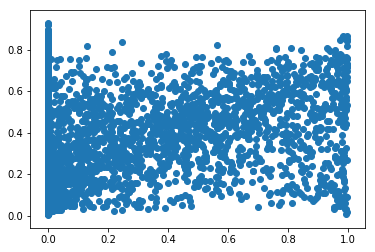

In [55]:
plt.scatter(SQ_train, log_preds_train)

(array([1815.,  253.,  193.,  160.,  191.,  173.,  145.,  129.,  129.,  212.]),
 array([0.     , 0.09966, 0.19932, 0.29899, 0.39865, 0.49831, 0.59797, 0.69763, 0.79729, 0.89696, 0.99662]),
 <a list of 10 Patch objects>)

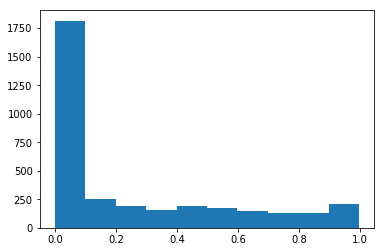

In [56]:
plt.hist(SQ_train)

(array([785., 403., 343., 347., 376., 351., 307., 241., 190.,  57.]),
 array([0.00301, 0.09543, 0.18785, 0.28027, 0.37269, 0.46511, 0.55752, 0.64994, 0.74236, 0.83478, 0.9272 ]),
 <a list of 10 Patch objects>)

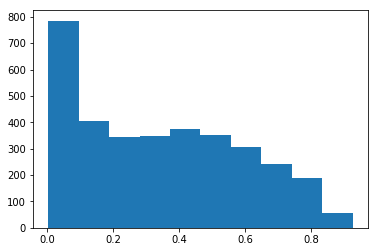

In [57]:
plt.hist(log_preds_train)

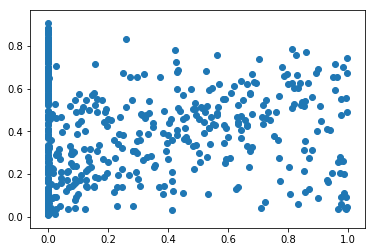

In [58]:
plt.scatter(SQ_valid, log_preds_valid)

(array([324.,  43.,  29.,  27.,  34.,  32.,  29.,  18.,  30.,  34.]),
 array([0.     , 0.09963, 0.19927, 0.2989 , 0.39853, 0.49817, 0.5978 , 0.69744, 0.79707, 0.8967 , 0.99634]),
 <a list of 10 Patch objects>)

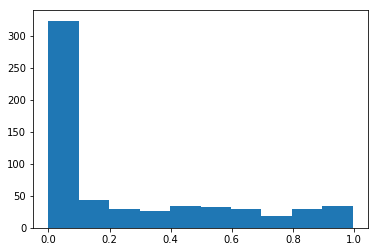

In [59]:
plt.hist(SQ_valid)

(array([145.,  63.,  62.,  55.,  58.,  72.,  52.,  49.,  25.,  19.]),
 array([0.00724, 0.0973 , 0.18735, 0.27741, 0.36746, 0.45752, 0.54757, 0.63762, 0.72768, 0.81773, 0.90779]),
 <a list of 10 Patch objects>)

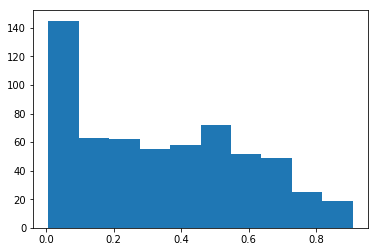

In [60]:
plt.hist(log_preds_valid)